In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
import io

c:\Users\danie_13ucdo4\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0


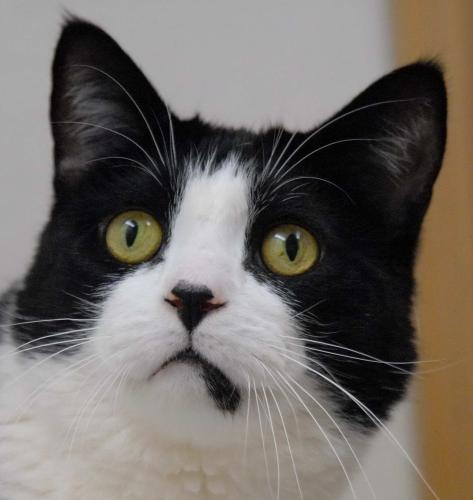

In [2]:
from datasets import load_dataset

train_dataset = load_dataset("rokmr/pets", split="train")
test_dataset = load_dataset("rokmr/pets", split="test")

#To view label
print(train_dataset[0]["label"])

#To view image
train_dataset[0]["image"]

In [3]:
type(train_dataset[400]["image"])

PIL.PngImagePlugin.PngImageFile

In [4]:
type(train_dataset[0]["image"])

PIL.JpegImagePlugin.JpegImageFile

In [6]:
def convert_gif_to_jpeg(example):
    image_data = example["image"]  # Assuming "image" is the key for the image data
    image = Image.open(io.BytesIO(image_data))
    
    # Check if the image is a GIF
    if hasattr(image, 'is_animated') and image.is_animated:
        # Convert GIF to JPEG
        jpeg_data = io.BytesIO()
        image.save(jpeg_data, format="JPEG")
        example["image"] = jpeg_data.getvalue()
    
    return example

In [7]:
transform = transforms.Compose([
            transforms.Resize((64, 64)),  # Resize images to (64, 64)
            transforms.ToTensor(),         # Convert PIL Image to PyTorch tensor
        ])

In [8]:
for i in range(0,899):
    tensor_img = transform(train_dataset[i]["image"])
    if tensor_img.shape[0] == 1:
        print(i)

233
426


In [9]:
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image

# Custom dataset class
class PetsDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
            transforms.Resize((64, 64)),  # Resize images to (64, 64)
            transforms.ToTensor(),         # Convert PIL Image to PyTorch tensor
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        if type(image) != 'PIL.JpegImagePlugin.JpegImageFile':
            image = image.convert("RGB")
        image = self.transform(image)
        
        return image

In [10]:
# Define the Convolutional Autoencoder model
class ConvAutoencoderRGB(nn.Module):
    def __init__(self):
        super(ConvAutoencoderRGB, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),  # Output values between 0 and 1 for RGB images
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoderRGB().to(device)

In [12]:
train_custom_dataset = PetsDataset(train_dataset)
test_custom_dataset = PetsDataset(test_dataset)

In [13]:
train_loader = DataLoader(train_custom_dataset, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(test_custom_dataset, batch_size=64, shuffle=False, num_workers=0)

In [14]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    for data in train_loader:
        img = data
        img = img.to(device)

        # Forward pass
        output = model(img)
        loss = criterion(output, img)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0655
Epoch [2/10], Loss: 0.0337
Epoch [3/10], Loss: 0.0306
Epoch [4/10], Loss: 0.0161
Epoch [5/10], Loss: 0.0163
Epoch [6/10], Loss: 0.0158
Epoch [7/10], Loss: 0.0146
Epoch [8/10], Loss: 0.0079
Epoch [9/10], Loss: 0.0164
Epoch [10/10], Loss: 0.0072


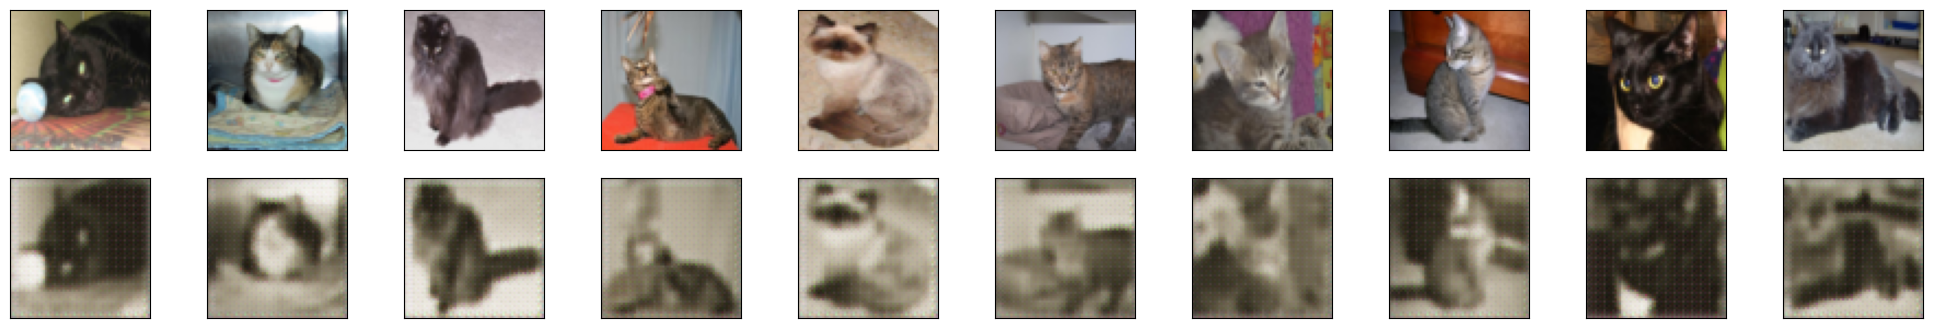

In [21]:
# Evaluate the model
model.eval()
with torch.no_grad():
    for data in test_loader:
        img = data
        img = img.to(device)
        recon = model(img)
        break

# Assuming img and recon are PyTorch tensors with shape (batch_size, channels, height, width)
img = img.to(device)
recon = recon.to(device)

# Convert tensors to numpy arrays
img = img.cpu().numpy().transpose((0, 2, 3, 1))  # Transpose to (batch_size, height, width, channels)
recon = recon.cpu().numpy().transpose((0, 2, 3, 1))

# Display original and reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25, 4))

for images, row in zip([img, recon], axes):
    for img, ax in zip(images, row):
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()